In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import transforms, datasets, models

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # to set the device as cuda supported gpu if available

In [4]:
# getting the dataset from github
!git clone https://github.com/jaddoescad/ants_and_bees.git

Cloning into 'ants_and_bees'...
remote: Enumerating objects: 408, done.
remote: Total 408 (delta 0), reused 0 (delta 0), pack-reused 408
Receiving objects: 100% (408/408), 45.03 MiB | 47.00 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [7]:
!ls ants_and_bees/train

ants  bees


In [9]:
# transformations to use only while training of the model
transform_train = transforms.Compose([transforms.Resize((224, 224)), # to resize the image as per trained model compatibility
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomAffine(0, shear = 10, scale = (0.8, 1.2)),
                                transforms.ColorJitter(brightness = 1, contrast = 1, saturation = 1),
                                transforms.ToTensor(), # to convert into tensor and also scale between 0 to 1
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # this normalizes the pixel values by setting mean, std = 0.5.
                                ])

# transformations to use during testing and validation
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
                                ])

training_dataset = datasets.ImageFolder(root='ants_and_bees/train', transform=transform_train)
validation_dataset = datasets.ImageFolder(root='ants_and_bees/val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size = 20, shuffle= True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 20, shuffle= False)

In [10]:
print(len(training_dataset))
print(len(validation_dataset))

244
153


In [14]:
classes = ('ant', 'bee') # it is important to give the class in order of the folders which will be read.

In [15]:
dataiter = iter(training_loader)
images, labels = dataiter.next()

In [16]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() # a note on the detach function below
    image = image.transpose(1,2,0) # swaps the places of the channels, the first would be moved to last, giving is (28, 28, 1)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) 
    image = image.clip(0, 1) # forcibly squashes the value to range between 0 and 1
    return image

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

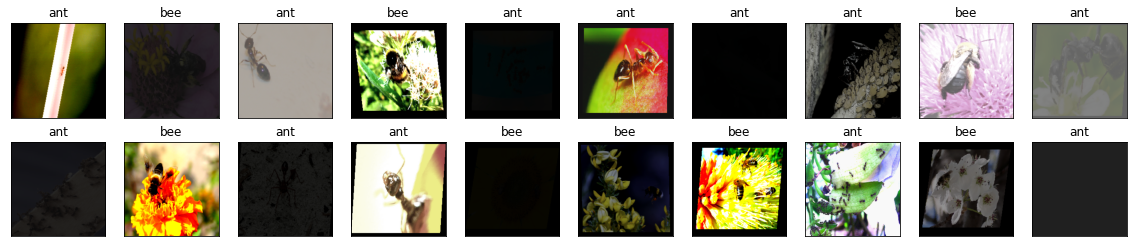

In [18]:
fig = plt.figure(figsize=(20, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

**tensor.detach()** creates a tensor that shares storage with tensor that does not require grad. It detaches the output from the computational graph. So no gradient will be backpropagated along this variable.

The wrapper with **torch.no_grad()** temporarily set all the ***requires_grad*** flag to false. ***torch.no_grad*** says that no operation should build the graph.

In [20]:
# Here we will define a pretrained model for learning the new data of ants and bees
# We will use the VGG Net
model = models.vgg16(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
# To not interfere with the pre-trained weights we will make all of its layers as un-trainable.
for param in model.features.parameters():
    param.requires_grad = False

In [22]:
# As we can observe that the model's last layer is not according to our problem, it has 1000 outputs while we need only two
# we will overwrite this layer with our own
n_inputs = model.classifier[6].in_features # getting the number of inputs that are required by the last layer
last_layer = nn.Linear(n_inputs, len(classes)) # creating a new linear layer with previous inputs and desired out neurons
model.classifier[6] = last_layer # overwriting the last layer
model.to(device)
print(model.classifier[6].out_features)

2


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [24]:
epochs = 5
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

# going through each epoch
for e in range(epochs):
    running_loss = 0
    running_corrects = 0 
    val_running_loss = 0
    val_running_corrects = 0

    # going through each batch
    for inputs, labels in training_loader:
        # inputs = inputs.view(inputs.shape[0], -1) we don't need these layers as we don't need 1D array initially for Conv.
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # calculating the prediction by getting the max probability class
        _, preds = torch.max(outputs, 1)

        # adding the losses for the batches
        running_loss += loss.item()
        # adding the accuracy for the batches
        running_corrects += torch.sum(preds == labels.data)

    else:

        # calculating the same metrics as above for validation set
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                # val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)

        # calculating the epoch loss
        epoch_loss = running_loss / len(training_loader.dataset) # .dataset is added to divide by total length of data, not batch
        # calculating the epoch accuracy
        epoch_acc = running_corrects.float() / len(training_loader.dataset)

        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        # calculating epoch loss and accuracy for validation set
        val_epoch_loss = val_running_loss / len(validation_loader.dataset) 
        val_epoch_acc = val_running_corrects / len(validation_loader.dataset)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('Epoch: ', (e+1))
        print('Training Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('Validation Loss: {:4f}, Validation Accuracy: {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

Epoch:  1
Training Loss: 0.0269, Accuracy: 0.7172
Validation Loss: 0.013841, Validation Accuracy: 0.9020
Epoch:  2
Training Loss: 0.0167, Accuracy: 0.8648
Validation Loss: 0.013806, Validation Accuracy: 0.9085
Epoch:  3
Training Loss: 0.0199, Accuracy: 0.8484
Validation Loss: 0.016915, Validation Accuracy: 0.8954
Epoch:  4
Training Loss: 0.0200, Accuracy: 0.8484
Validation Loss: 0.012403, Validation Accuracy: 0.9281
Epoch:  5
Training Loss: 0.0135, Accuracy: 0.8770
Validation Loss: 0.012261, Validation Accuracy: 0.9412


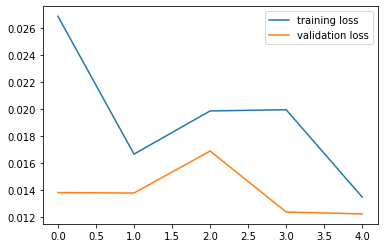

In [25]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(val_running_loss_history, label = 'validation loss')
plt.legend()
plt.show()

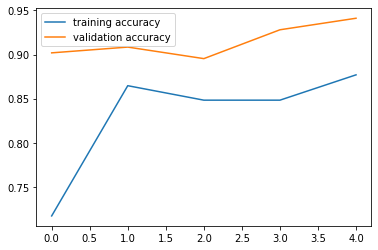

In [26]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(val_running_corrects_history, label = 'validation accuracy')
plt.legend()
plt.show()

We can now try with a random image from the internet to validate out model.

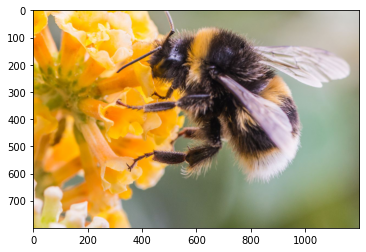

In [27]:
import PIL.ImageOps
import requests
from PIL import Image

url = 'https://cdn.vox-cdn.com/thumbor/TdjLfYgyy54QNDooQguJSjRXD4s=/0x243:2500x2118/1200x800/filters:focal(0x243:2500x2118)/cdn.vox-cdn.com/uploads/chorus_image/image/46679984/shutterstock_150559442.0.0.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img);

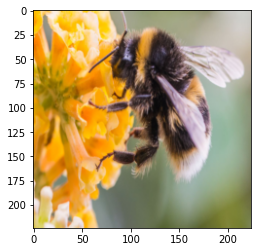

In [28]:
# We have to transform out image so be similar to the ones we have in the MNIST training set.
img = transform(img)
plt.imshow(im_convert(img))

In [29]:
# feeding it to the model and getting the output
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

bee


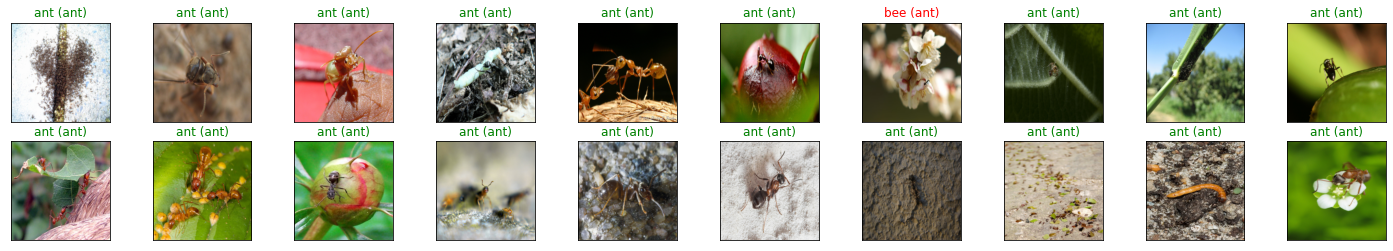

In [30]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))